<a href="https://colab.research.google.com/github/Himanshu-1703/reddit-sentiment-analysis/blob/main/BERT_Embeddings_on_reddit_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Packages

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import missingno
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly.express as px
from collections import Counter
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

# Load Data

In [ ]:
# load the data

DATA_PATH = r"https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv"

df = pd.read_csv(DATA_PATH)

df

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [ ]:
# rename columns

df.rename({"clean_comment":"comment",
           "category":"sentiment"},axis=1,inplace=True)

In [ ]:
# missing data

df.isna().sum()

,0
comment,100
sentiment,0


**There are 100 missing values in the comment**

<Axes: >

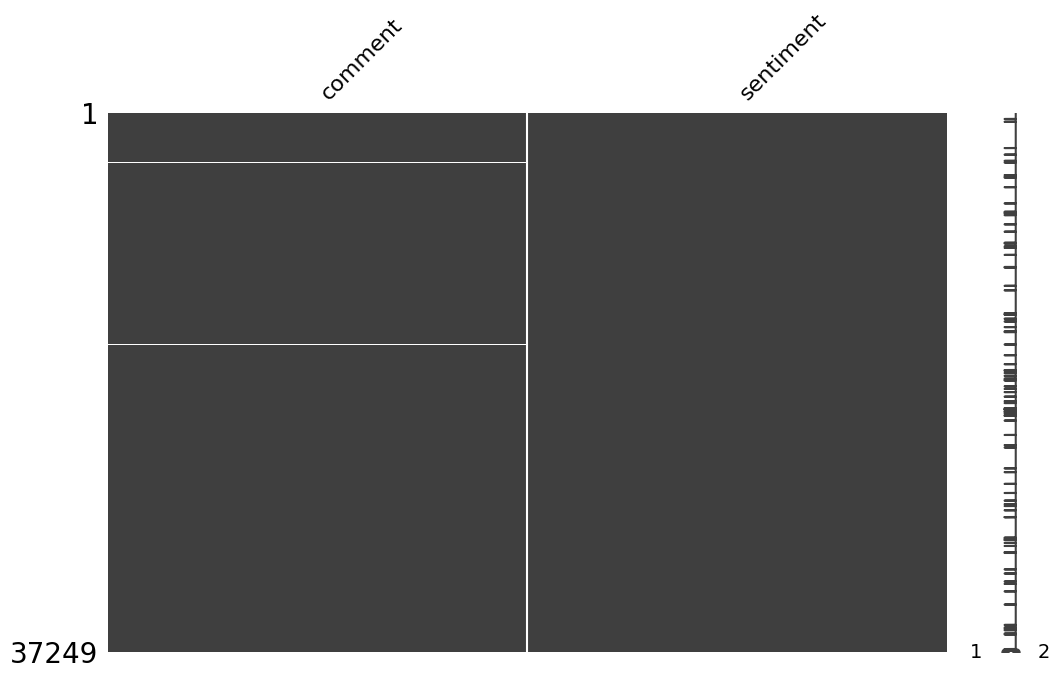

In [ ]:
# missing values matrix

missingno.matrix(df,figsize=(12,7))

In [ ]:
# rows that have missing values

(
    df.loc[
        df['comment'].isna()
    ]
)

,comment,sentiment
413,NaN,0
605,NaN,0
2422,NaN,0
2877,NaN,0
3307,NaN,0
...,...,...
35975,NaN,0
36036,NaN,0
37043,NaN,0
37111,NaN,0


In [ ]:
# sentiment of rows that have missing values

(
    df.loc[
        df['comment'].isna(),"sentiment"
    ]
    .value_counts()
)

,count
sentiment,
0,100


**All rows that have missing values have been labelled the sentiment of 0 (neutral)**

In [ ]:
# check for duplicate comments in the data

print(df['comment'].dropna().duplicated().sum())

350


**`350` comments in the data are duplicated**

In [ ]:
# shape of the data

data_rows, data_cols = df.shape
print(f'The data has {data_rows} rows and {data_cols} columns')

The data has 37249 rows and 2 columns


In [ ]:
# comments having words like modi,bjp and congress

(
    df
    .dropna()
    .loc[(lambda df_: df_['comment'].str.contains(r"bjp|congress|modi")),"comment"]
)

,comment
51,tea partier expresses support for namo after ...
68,can congress eliminate namo and blame advani
69,don know but surely there his statue every bj...
70,after seeing this uvjx3kwoehw video seems anyt...
72,congress needs bogeyman modi without the bad g...
...,...
37210,modi april fool
37228,also modiji will give award ravish kumar tonight
37236,fan modi but some the best people ever met li...
37245,kya bhai pure saal chutiya banaya modi aur jab...


In [ ]:
# distribution of such comments

print(
      df['comment']
      .dropna()
      .str.contains(r"bjp|congress|modi")
      .mean() * 100
    )

18.991089935126112


# Data Cleaning

In [ ]:
len(df.loc[14037,'comment'].split())

2

In [ ]:
# check for rows that have empty rows, only whitespace and new line characters

whitespace_chars = [" ","\n"]

df.loc[df['comment'].isin(whitespace_chars),"comment"]

,comment
181,
375,
392,
651,
1222,
...,...
35711,
35778,
35987,
36707,


In [ ]:
def remove_whitespaces(ser):
    return ser.str.lstrip().str.rstrip()

def remove_whitespace_chars(ser):
    chars_list = [" ","\n"]
    return ser[ser.isin(chars_list)]

def count_words(text):
    return len(text.split(" "))

def removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    return text

def removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def clean_text(text):
    text = removing_numbers(text)
    text = removing_punctuations(text)
    text = removing_urls(text)
    return text

def sentence_length(ser):
    bins = [0,10, 25, 50, ser.max()]
    labels = ['Short', 'Medium', 'Long', 'Very Long']
    return pd.cut(ser,bins=bins,labels=labels)

def is_response(ser):
    return np.where(ser <= 3, 1, 0)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

def lemmatize(text):
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text.split(" ")]
    return " ".join(text)


In [ ]:
def remove_emoji(text):
    # Regex pattern to match all emoji characters
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
        u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended-A
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_non_ascii(text):
    # Remove all non-ASCII characters
    return re.sub(r'[^\x00-\x7F]+', '', text)

def remove_chinese(text):
    # Regex to remove Chinese characters (CJK Unified Ideographs)
    return re.sub(r'[\u4e00-\u9fff]+', '', text)

def clean_unicode_text(text):
    # Apply all cleaning functions
    text = remove_emoji(text)
    text = remove_chinese(text)
    text = remove_non_ascii(text)
    return text

In [ ]:
df['comment'].dropna().apply(count_words)

,comment
0,41
1,197
2,87
3,30
4,113
...,...
37244,1
37245,19
37246,8
37247,3


In [ ]:
def count_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    stop_words_only = [word for word in word_tokens if word.lower() in stop_words]
    return len(stop_words_only)

def count_negative_stop_words(text):
    negative_stop_words = ["but","however","not","neither","no","nothing"]
    word_tokens = word_tokenize(text)
    neg_stop_words = [word for word in word_tokens if word.lower() in negative_stop_words]
    return len(neg_stop_words)

In [ ]:
df['comment'].dropna().sample(25).apply(count_stop_words)

,comment
32287,8
29398,65
22292,14
17775,1
23957,5
31612,11
20025,2
13647,4
22550,16
32474,0


In [ ]:
def count_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    # Define POS categories
    nouns = ['NN', 'NNS', 'NNP', 'NNPS']
    verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    adjectives = ['JJ', 'JJR', 'JJS']

    # Count the POS tags
    pos_counts = Counter(tag for word, tag in pos_tags)

    num_nouns = sum(pos_counts[pos] for pos in nouns)
    num_verbs = sum(pos_counts[pos] for pos in verbs)
    num_adjectives = sum(pos_counts[pos] for pos in adjectives)
    return pd.Series({'nouns': num_nouns, 'verbs': num_verbs, 'adjectives': num_adjectives})

In [ ]:
def clean_data(data):

    return (
        data
        .dropna()
        .drop_duplicates(subset=['comment'])
        .loc[lambda df_: ~df_['comment'].isin([" ","\n"])]
        .assign(
            stop_words_count = lambda df_: df_.loc[:,'comment'].apply(count_stop_words),
            neg_stop_words_count = lambda df_: df_.loc[:,'comment'].apply(count_negative_stop_words)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(clean_text)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].str.lstrip().str.rstrip().str.lower(),
            word_count = lambda df_: df_.loc[:,"comment"].apply(count_words),
            named_sentiment = lambda df_: df_.loc[:,"sentiment"].replace({0:"neutral",
                                                                         -1:"negative",
                                                                          1:"positive"}),
            sentence_length = lambda df_: df_.loc[:,"word_count"].pipe(sentence_length),
            response = lambda df_: df_.loc[:,"word_count"].pipe(is_response)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(removing_punctuations)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(clean_unicode_text)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(remove_stopwords)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(lemmatize)
        )
        .loc[lambda df_: ~(df_['comment'].str.contains(r"bjp|congress|modi")),:]
    )

In [ ]:
final_df = clean_data(df)

In [ ]:
final_df.sample(30)

,comment,sentiment,stop_words_count,neg_stop_words_count,word_count,named_sentiment,sentence_length,response
26762,shut fuck discussing science,-1,1,0,8,negative,Short,0
22687,yeo one pentagon think got nominated uption ko...,-1,2,2,11,negative,Medium,0
13,recently heard similar question person asked i...,1,36,1,97,positive,Very Long,0
88,let talk elephant room regardless medium want ...,1,13,0,31,positive,Long,0
11198,lot lot lot lot lot lot lot lot lot lot lot lo...,0,32,0,48,neutral,Long,0
5929,sound like isi,1,0,0,3,positive,Short,1
25170,many word stop buying shit edit clear everythi...,1,24,1,72,positive,Very Long,0
2486,good idea health care may seem benefit corpora...,1,16,0,50,positive,Long,0
4179,everyone want peaceful stable job,1,3,0,8,positive,Short,0
26574,every time open mouth cement place history hum...,1,4,0,14,positive,Medium,0


In [ ]:
# form the pos tag count data

pos_tag_data = final_df['comment'].apply(count_pos_tags)

In [ ]:
pos_tag_data

,nouns,verbs,adjectives
0,16,4,2
1,58,30,24
2,18,7,10
3,7,4,2
4,20,19,12
...,...,...,...
37242,8,0,0
37243,7,5,2
37244,1,0,0
37246,4,0,1


In [ ]:
final_df = final_df.join(pos_tag_data)

In [ ]:
# check cleaned df for missing values

final_df.isna().sum()

,0
comment,0
sentiment,0
stop_words_count,0
neg_stop_words_count,0
word_count,0
named_sentiment,0
sentence_length,0
response,0
nouns,0
verbs,0


In [ ]:
# shape of cleaned data

final_df.shape

(29751, 11)

In [ ]:
# save the cleaned data as csv

final_df.to_csv("cleaned_data.csv",index=False)

# EDA

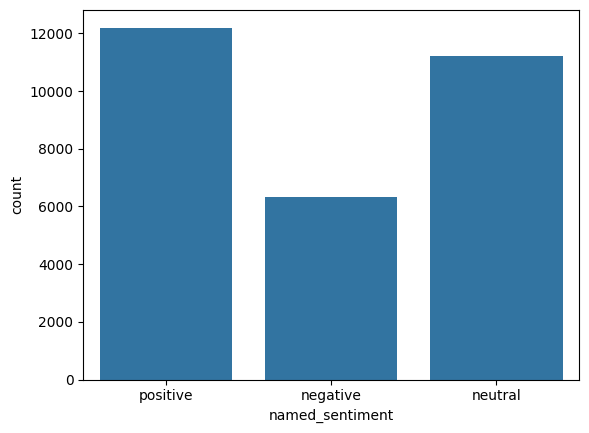

In [ ]:
# distribution of classes

sns.countplot(data=final_df,x="named_sentiment");

**Clearly the data shows class imbalance**

In [ ]:
# frequency distribution of sentiments

final_df['named_sentiment'].value_counts(normalize=True).mul(100).round(2)

,proportion
named_sentiment,
positive,41.01
neutral,37.68
negative,21.31


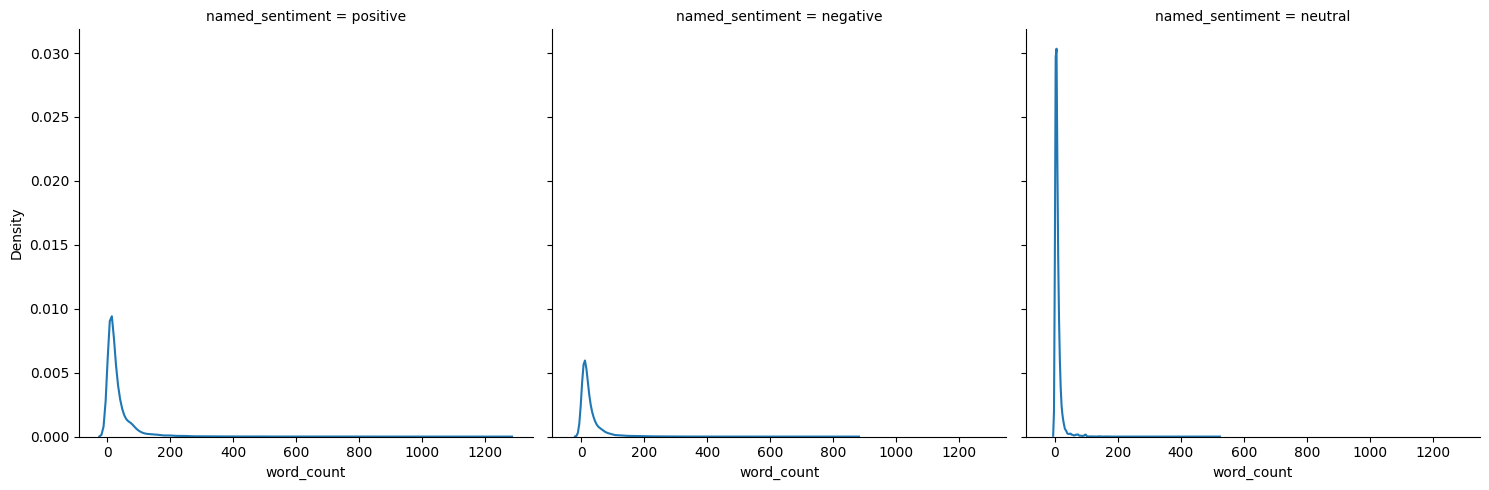

In [ ]:
# distribution of word_count per sentiment

sns.displot(final_df,x='word_count',col='named_sentiment',kind='kde');

<Axes: xlabel='word_count', ylabel='Density'>

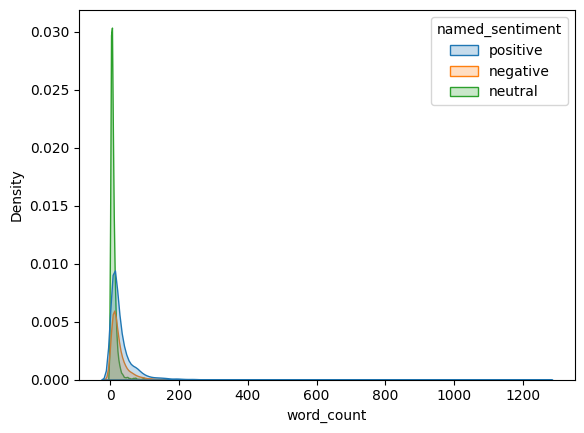

In [ ]:
# distribution of word_count per sentiment

sns.kdeplot(final_df,x='word_count',hue='named_sentiment',fill=True)

In [ ]:
# statistical summary of word_count

sentiment_grp = final_df.groupby("named_sentiment")

sentiment_grp['word_count'].agg(["min","max","median","mean"])

,min,max,median,mean
named_sentiment,,,,
negative,1,862,17.0,28.119577
neutral,1,518,6.0,9.372435
positive,1,1258,18.0,34.547369


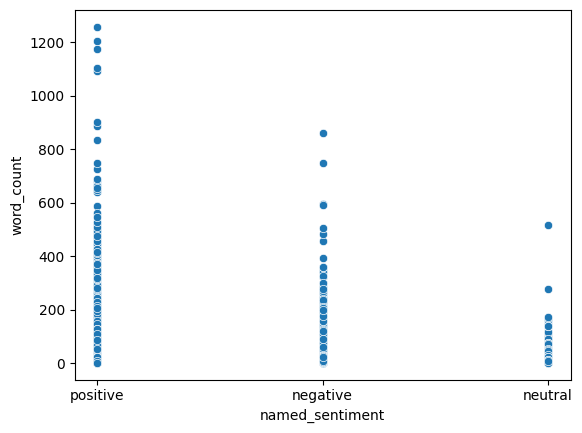

In [ ]:
#sentiment vs word_count

sns.scatterplot(final_df,x='named_sentiment',y='word_count');

In [ ]:
# sentiment vs word count --> boxplots

px.box(data_frame=final_df,x='named_sentiment',y='word_count')

In [ ]:
# distribution of sentence length based on sentiment

pd.crosstab(index=final_df['named_sentiment'],columns=final_df['sentence_length'],normalize=True).mul(100)

sentence_length,Short,Medium,Long,Very Long
named_sentiment,,,,
negative,6.440120,7.835031,4.144399,2.887298
neutral,27.720077,8.117374,1.230211,0.611744
positive,12.480253,13.249975,7.912339,7.371181


In [ ]:
import warnings

warnings.filterwarnings("ignore")
fig = px.sunburst(final_df,path=['named_sentiment','sentence_length'],width=700,height=700)
fig.show()

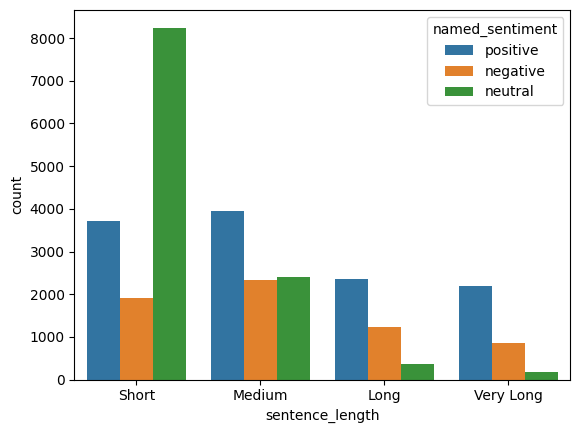

In [ ]:
# sentence length distribution among sentences

sns.countplot(final_df,x='sentence_length',hue='named_sentiment');

<Axes: xlabel='stop_words_count', ylabel='Density'>

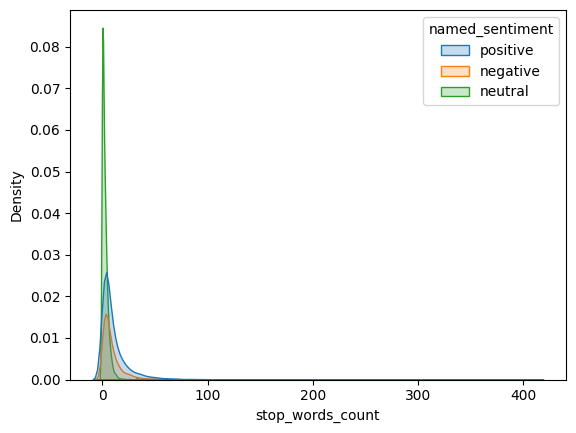

In [ ]:
# kdeplot of stopwords count

sns.kdeplot(final_df,x='stop_words_count',hue='named_sentiment',fill=True)

<Axes: xlabel='neg_stop_words_count', ylabel='Density'>

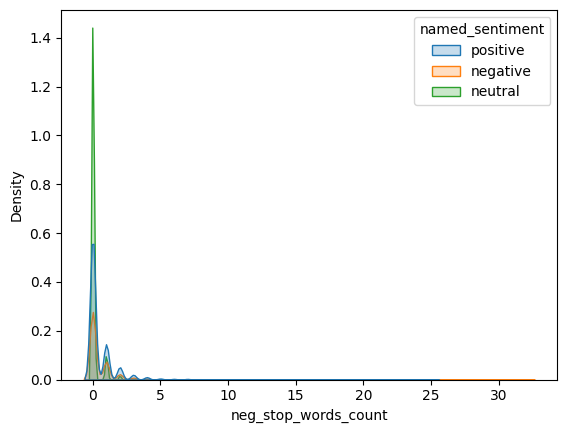

In [ ]:
# kdeplot of  negative stopwords count

sns.kdeplot(final_df,x='neg_stop_words_count',hue='named_sentiment',fill=True)

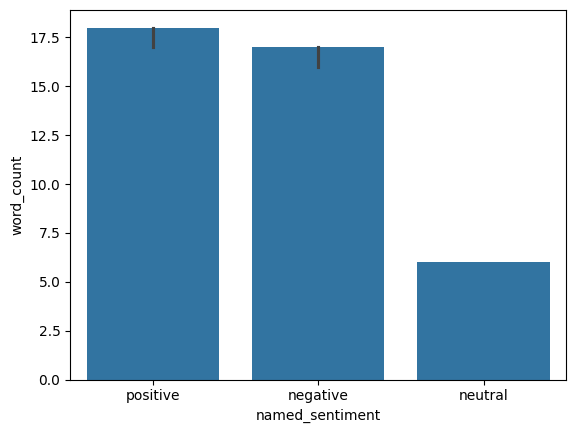

In [ ]:
# median word counts among sentiments

sns.barplot(final_df,x='named_sentiment',y='word_count',estimator='median');

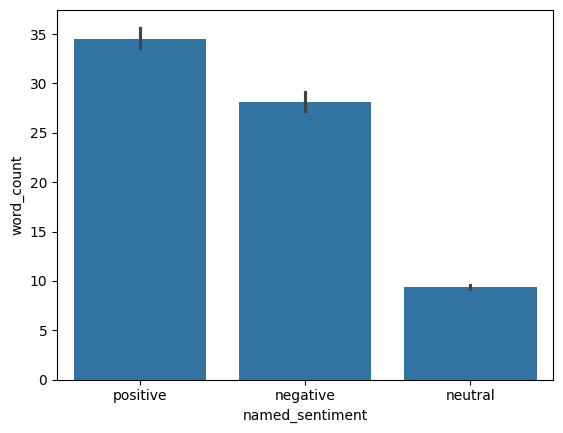

In [ ]:
# avg word counts among sentiments

sns.barplot(final_df,x='named_sentiment',y='word_count',estimator='mean');

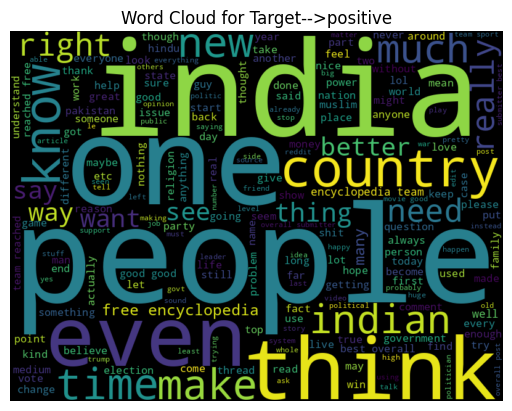

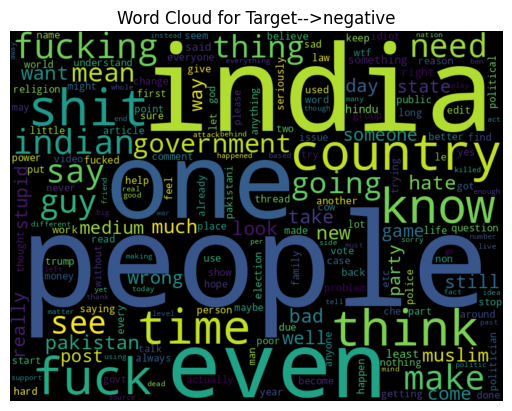

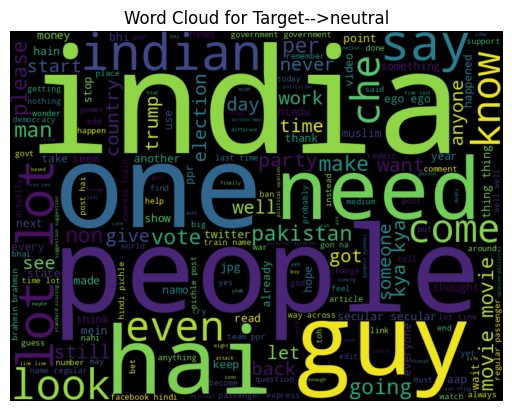

In [ ]:
# plot wordclouds for each sentiment

def plot_wordcloud(target_class):
    text = ' '.join(final_df.loc[(final_df['named_sentiment'] == target_class),"comment"])
    wordcloud = WordCloud(width=800, height=600).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Target-->{target_class}')
    plt.show()

for sentiment in final_df['named_sentiment'].unique().tolist():
    plot_wordcloud(sentiment)

In [ ]:
# top 15 words and their count in each sentiment

def tokenize_sentences(text):
    tokens = nltk.word_tokenize(text)
    return tokens

tokens = final_df.loc[:,"comment"].apply(tokenize_sentences)

positive_tokens = tokens.loc[final_df['named_sentiment'] == "positive"].sum()
neutral_tokens = tokens.loc[final_df['named_sentiment'] == "neutral"].sum()
negative_tokens = tokens.loc[final_df['named_sentiment'] == "negative"].sum()

In [ ]:
# find the top 15 words

def get_top_words(tokens, n=10):
    word_counts = Counter(tokens)
    return word_counts.most_common(n)

top_15_positive = get_top_words(positive_tokens,15)
top_15_neutral = get_top_words(neutral_tokens,15)
top_15_negative = get_top_words(negative_tokens,15)

print("Top 10 words for Positive sentiment:", top_15_positive)
print("Top 10 words for Neutral sentiment:", top_15_neutral)
print("Top 10 words for Negative sentiment:", top_15_negative)

Top 10 words for Positive sentiment: [('good', 2358), ('people', 2222), ('like', 2080), ('india', 1894), ('one', 1665), ('would', 1399), ('get', 1336), ('time', 1173), ('even', 1123), ('think', 1073), ('right', 1056), ('thing', 1003), ('make', 985), ('indian', 985), ('know', 943)]
Top 10 words for Neutral sentiment: [('like', 540), ('india', 497), ('hai', 458), ('lot', 434), ('one', 391), ('time', 351), ('people', 313), ('get', 284), ('think', 261), ('thing', 245), ('che', 222), ('guy', 219), ('indian', 216), ('post', 208), ('kya', 205)]
Top 10 words for Negative sentiment: [('people', 1010), ('like', 894), ('india', 838), ('one', 719), ('get', 567), ('indian', 510), ('shit', 501), ('fuck', 493), ('thing', 488), ('even', 482), ('time', 482), ('would', 449), ('country', 421), ('know', 406), ('think', 399)]


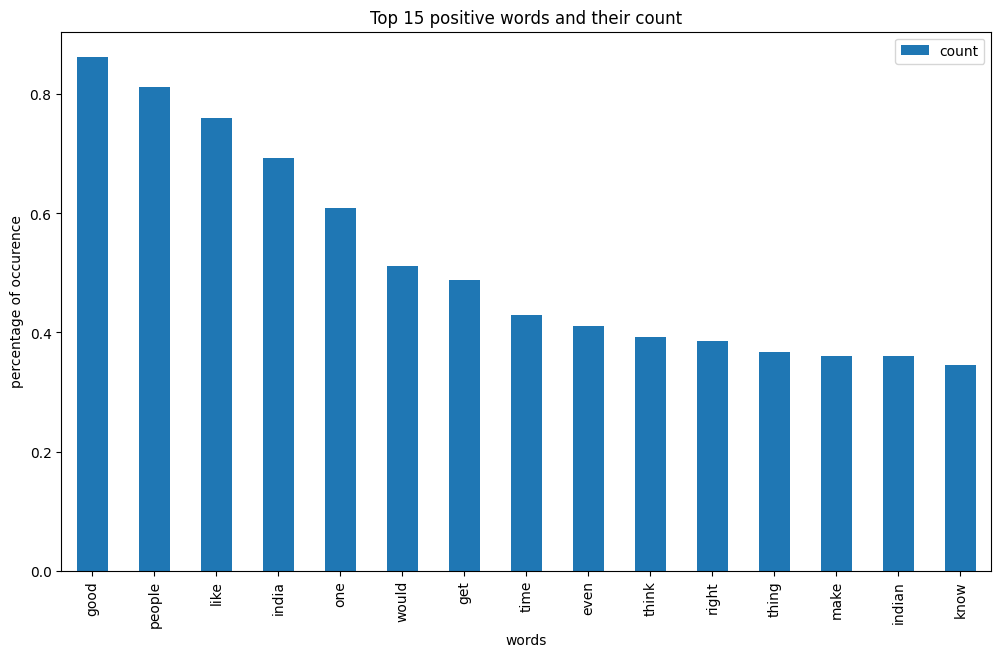

In [ ]:
# bar plot for top 15 positive sentiment words
(
    pd.DataFrame(top_15_positive,columns=['word','count'])
    .set_index('word')
    .div(len(positive_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 positive words and their count")
plt.show()

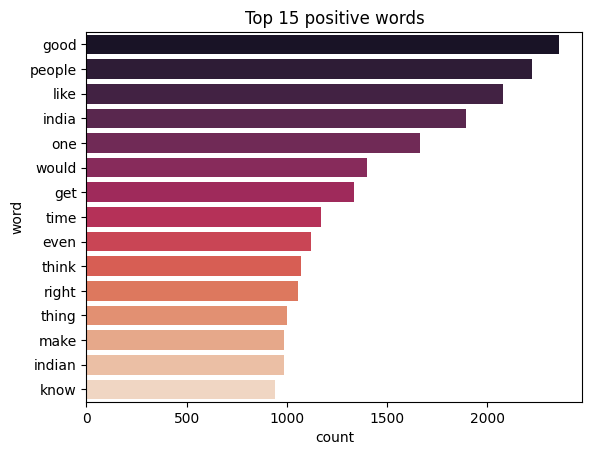

In [ ]:
# plot the top 15 positive words

sns.barplot(data=pd.DataFrame(top_15_positive,columns=['word','count']),
            x='count',y='word',palette='rocket')
plt.title("Top 15 positive words")
plt.show()

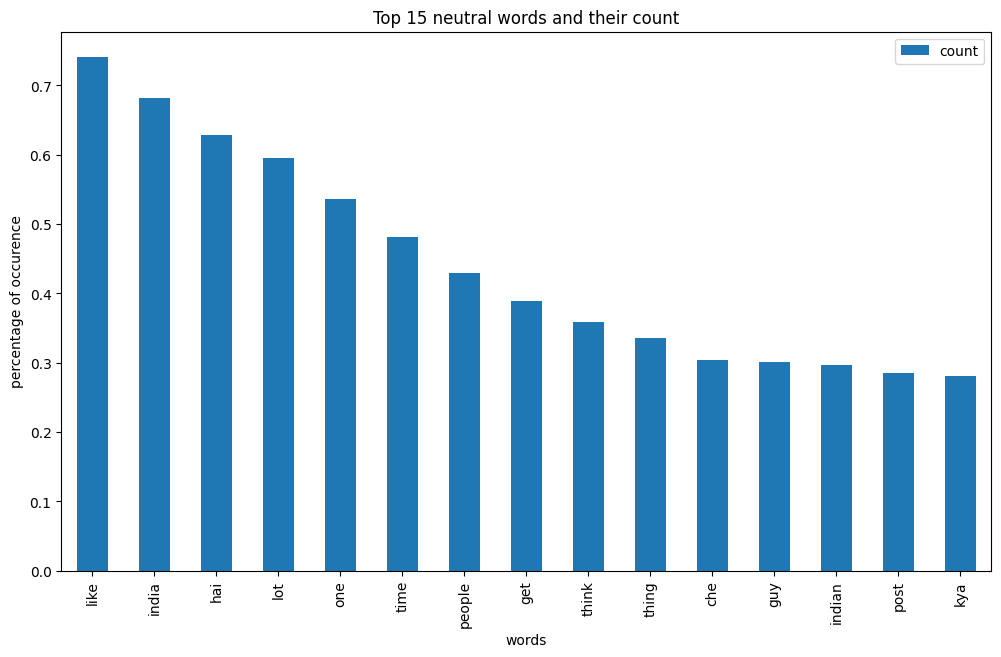

In [ ]:
# bar plot for top 15 neutral sentiment words
(
    pd.DataFrame(top_15_neutral,columns=['word','count'])
    .set_index('word')
    .div(len(neutral_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 neutral words and their count")
plt.show()

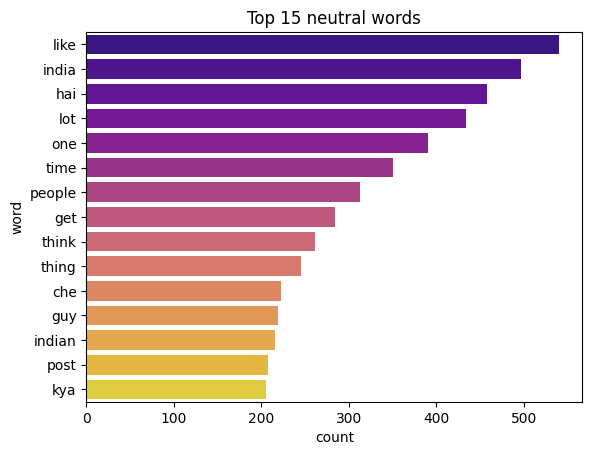

In [ ]:
# plot the top 15 neutral words

sns.barplot(data=pd.DataFrame(top_15_neutral,columns=['word','count']),
            x='count',y='word',palette='plasma')
plt.title("Top 15 neutral words")
plt.show()

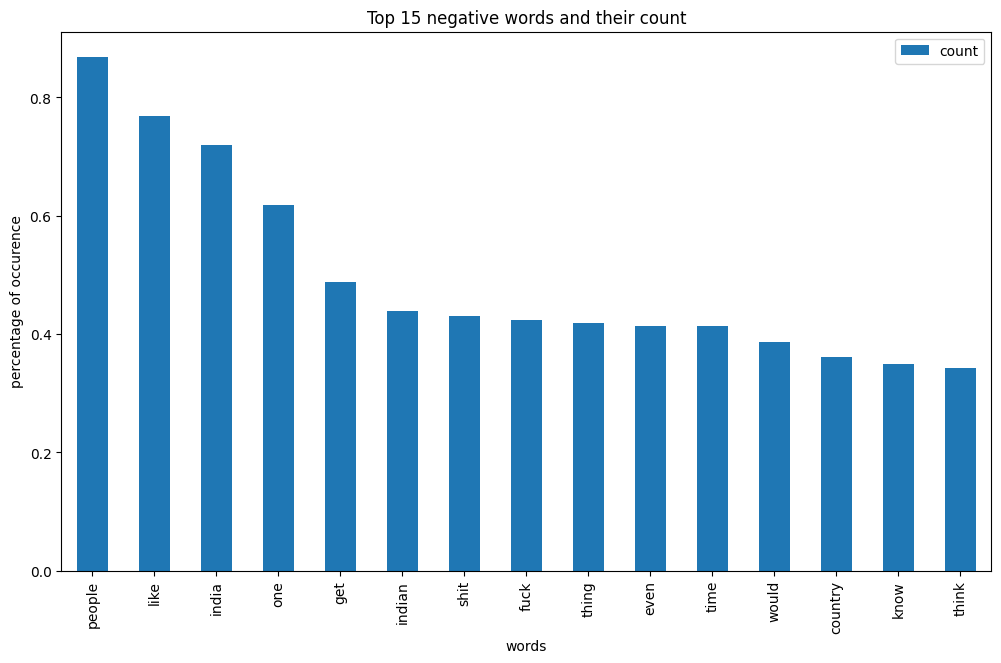

In [ ]:
# bar plot for top 15 negative sentiment words
(
    pd.DataFrame(top_15_negative,columns=['word','count'])
    .set_index('word')
    .div(len(negative_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 negative words and their count")
plt.show()

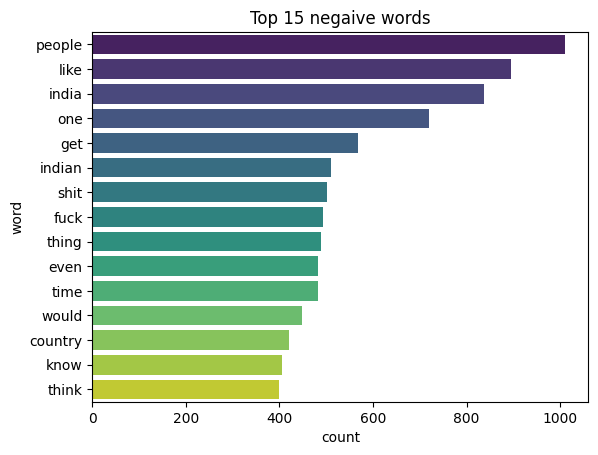

In [ ]:
# plot the top 15 negative words

sns.barplot(data=pd.DataFrame(top_15_negative,columns=['word','count']),
            x='count',y='word',palette='viridis')
plt.title("Top 15 negaive words")
plt.show()

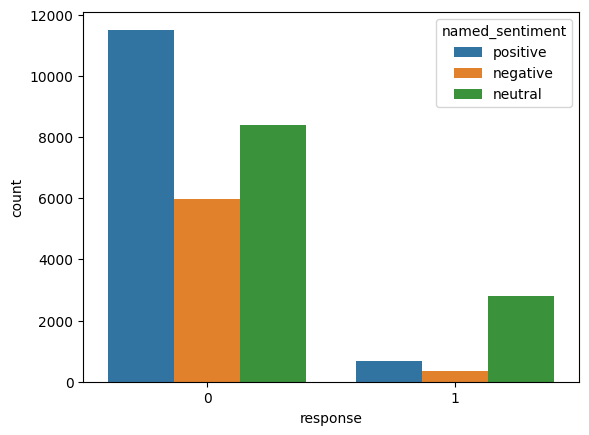

In [ ]:
# distribution of responses among sentiments
sns.countplot(final_df,x='response',hue='named_sentiment');

**Response** --> This column denotes those comments which are a length of 3 or less words, which cannot be considered a comment but are feedbacks or responses

In [ ]:
# response comments

(
    final_df
    .loc[(final_df['response'] == 1),"comment"]
)

,comment
18,zarus
46,nam indeed
47,jbdbxpxga
71,law headline
92,dry state
...,...
37230,nice try
37235,
37239,pmd
37244,jesus


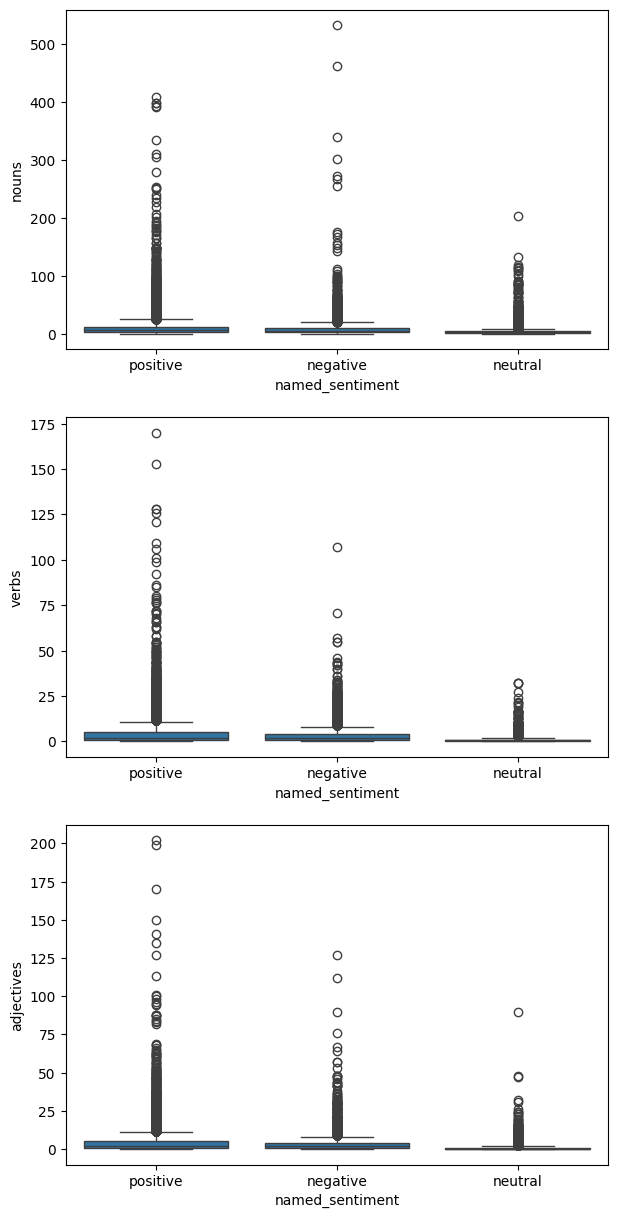

In [ ]:
# boxplots for pos tags for each sentiment

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,15))

for ind,y in enumerate(final_df.columns[-3:].to_list()):
    sns.boxplot(data=final_df,x='named_sentiment',y=y,ax=ax[ind])

In [ ]:
from math import floor

In [ ]:
# statistical summary

sentiment_grp[['nouns','adjectives','verbs']].agg(["median","mean"]).map(floor)

nouns      adjectives       verbs     
                median mean     median mean median mean
named_sentiment                                        
negative             5    9          2    3      2    3
neutral              3    4          0    0      1    0
positive             6   10          2    4      2    4

# Model Pipeline

In [ ]:
final_df.head()

,comment,sentiment,stop_words_count,neg_stop_words_count,word_count,named_sentiment,sentence_length,response,nouns,verbs,adjectives
0,family mormon never tried explain still stare ...,1,13,0,39,positive,Long,0,16,4,2
1,buddhism much lot compatible christianity espe...,1,59,3,196,positive,Very Long,0,58,30,24
2,seriously say thing first get complex explain ...,-1,40,0,86,negative,Very Long,0,18,7,10
3,learned want teach different focus goal wrappi...,0,15,1,29,neutral,Long,0,7,4,2
4,benefit may want read living buddha living chr...,1,45,1,112,positive,Very Long,0,20,19,12


In [ ]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from feature_engine.encoding import CountFrequencyEncoder

## Feature Engineering

### Comments

In [ ]:
count_vec = CountVectorizer(decode_error='ignore',
                            stop_words='english',
                            min_df=3)
count_vec.fit_transform(final_df['comment'].sample(30)).toarray()

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0]])

### Scaling

In [ ]:
# scaling columns

cols_to_scale = ['word_count','stop_words_count','nouns','adjectives','verbs',"neg_stop_words_count"]

scaler = RobustScaler()

scaler.set_output(transform='pandas')

scaler.fit_transform(final_df[cols_to_scale])

,word_count,stop_words_count,nouns,adjectives,verbs,neg_stop_words_count
0,1.473684,1.285714,2.000000,0.333333,1.000000,0.0
1,9.736842,7.857143,9.000000,7.666667,9.666667,3.0
2,3.947368,5.142857,2.333333,3.000000,2.000000,0.0
3,0.947368,1.571429,0.500000,0.333333,1.000000,1.0
4,5.315789,5.857143,2.666667,3.666667,6.000000,1.0
...,...,...,...,...,...,...
37242,0.000000,-0.142857,0.666667,-0.333333,-0.333333,0.0
37243,0.578947,0.285714,0.500000,0.333333,1.333333,0.0
37244,-0.526316,-0.571429,-0.500000,-0.333333,-0.333333,0.0
37246,-0.263158,-0.571429,0.000000,0.000000,-0.333333,0.0


### Encoding

In [ ]:
# categories in sentence length

final_df['sentence_length'].unique()

['Long', 'Very Long', 'Medium', 'Short']
Categories (4, object): ['Short' < 'Medium' < 'Long' < 'Very Long']

In [ ]:
ord_encoder = OrdinalEncoder(categories=[['Short','Medium','Long','Very Long']])
ord_encoder.set_output(transform='pandas')
ord_encoder.fit_transform(final_df[['sentence_length']])

ord_encoder.categories_

[array(['Short', 'Medium', 'Long', 'Very Long'], dtype=object)]

In [ ]:
# count encoding

count_enc = CountFrequencyEncoder(encoding_method='frequency')
count_enc.set_output(transform='pandas')
count_enc.fit_transform(final_df[['sentence_length']])

,sentence_length
0,0.132869
1,0.108702
2,0.108702
3,0.132869
4,0.108702
...,...
37242,0.292024
37243,0.292024
37244,0.466404
37246,0.466404


In [ ]:
sentence_union = FeatureUnion([
    ('count_enc',count_enc),
    ('ord_encoder',ord_encoder)
])

sentence_union.set_output(transform='pandas')

sentence_union.fit_transform(final_df[['sentence_length']])

,count_enc__sentence_length,ord_encoder__sentence_length
0,0.132869,2.0
1,0.108702,3.0
2,0.108702,3.0
3,0.132869,2.0
4,0.108702,3.0
...,...,...
37242,0.292024,1.0
37243,0.292024,1.0
37244,0.466404,0.0
37246,0.466404,0.0


In [ ]:
# pipeline of sentence length column

sentence_pipe = Pipeline([
    ('sentence_union',sentence_union),
    ('scale',MinMaxScaler())
])

sentence_pipe.set_output(transform='pandas')

sentence_pipe.fit_transform(final_df[['sentence_length']])

,count_enc__sentence_length,ord_encoder__sentence_length
0,0.067562,0.666667
1,0.000000,1.000000
2,0.000000,1.000000
3,0.067562,0.666667
4,0.000000,1.000000
...,...,...
37242,0.512498,0.333333
37243,0.512498,0.333333
37244,1.000000,0.000000
37246,1.000000,0.000000


In [ ]:
# make X and y

X = final_df.drop(columns=['sentiment','named_sentiment'])
y = final_df['named_sentiment']

In [ ]:
X

,comment,stop_words_count,neg_stop_words_count,word_count,sentence_length,response,nouns,verbs,adjectives
0,family mormon never tried explain still stare ...,13,0,39,Long,0,16,4,2
1,buddhism much lot compatible christianity espe...,59,3,196,Very Long,0,58,30,24
2,seriously say thing first get complex explain ...,40,0,86,Very Long,0,18,7,10
3,learned want teach different focus goal wrappi...,15,1,29,Long,0,7,4,2
4,benefit may want read living buddha living chr...,45,1,112,Very Long,0,20,19,12
...,...,...,...,...,...,...,...,...,...
37242,hona hai vaccination education insurance end m...,3,0,11,Medium,0,8,0,0
37243,agree push make nation either pity pakistan in...,6,0,22,Medium,0,7,5,2
37244,jesus,0,0,1,Short,1,1,0,0
37246,downvote karna tha par upvote hogaya,0,0,6,Short,0,4,0,1


In [ ]:
y

,named_sentiment
0,positive
1,positive
2,negative
3,neutral
4,positive
...,...
37242,neutral
37243,negative
37244,neutral
37246,neutral


In [ ]:
# train test split with test size 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=42,stratify=y)

X_train

,comment,stop_words_count,neg_stop_words_count,word_count,sentence_length,response,nouns,verbs,adjectives
23054,gajab fakir hai hamare kaka,0,0,5,Short,0,5,0,0
33846,never gon na happen felix giving number always...,7,0,17,Medium,0,4,3,1
22590,people need elaborate mean democracy people re...,17,2,40,Long,0,12,2,7
223,harsh send keeper friendly,3,0,7,Short,0,1,1,1
16425,pas ipcc,1,0,3,Short,1,2,0,0
...,...,...,...,...,...,...,...,...,...
5033,another thing understand whenever celebrity tw...,22,1,60,Very Long,0,16,8,4
31749,literally post another sub telling worried ind...,12,0,30,Long,0,8,2,6
31306,year old person remember many thing messed nat...,23,0,69,Very Long,0,17,9,11
27772,fellow english speaker found amitabha easy eno...,32,0,74,Very Long,0,16,8,13


In [ ]:
# shapes of X_train and X_test

print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')

The shape of X_train is (23800, 9)
The shape of X_test is (5951, 9)


In [ ]:
# class distributions of y_train and y_test

print(y_train.value_counts(normalize=True))
print("*" * 30)
print(y_test.value_counts(normalize=True))

named_sentiment
positive    0.410126
neutral     0.376807
negative    0.213067
Name: proportion, dtype: float64
******************************
named_sentiment
positive    0.410183
neutral     0.376743
negative    0.213073
Name: proportion, dtype: float64


In [ ]:
# label encode y_train and y_test

le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
# preprocessor

preprocessor = ColumnTransformer([
    #('count_vec',count_vec,'comment'),
    ('scale',scaler,cols_to_scale),
    ('sentence_pipe',sentence_pipe,['sentence_length'])
],remainder='drop',n_jobs=-1)

preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('scale', RobustScaler(),
                                 ['word_count', 'stop_words_count', 'nouns',
                                  'adjectives', 'verbs',
                                  'neg_stop_words_count']),
                                ('sentence_pipe',
                                 Pipeline(steps=[('sentence_union',
                                                  FeatureUnion(transformer_list=[('count_enc',
                                                                                  CountFrequencyEncoder(encoding_method='frequency')),
                                                                                 ('ord_encoder',
                                                                                  OrdinalEncoder(categories=[['Short',
                                                                                                              'Medium',
                                                                                                              'Long',
                                                                                                              'Very '
                                                                                                              'Long']]))])),
                                                 ('scale', MinMaxScaler())]),
                                 ['sentence_length'])])

## BERT Embeddings

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# max length of sentence

max_length = 128

max_length

128

In [ ]:
def encode_text(text):
    # Tokenize the text
    tokens = tokenizer(text.tolist(),
                    add_special_tokens=True,
                    max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='tf')
    return tokens

In [ ]:
def get_bert_embeddings(text):
    tokens = encode_text(text)
    outputs = model(tokens)
    pooled_output = outputs.last_hidden_state[:, 0, :]
    return pooled_output.numpy()

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def batched_embeddings(text,batch_size=32):
    embeddings = []
    for index in tqdm(range(0,len(text),batch_size),desc="Progress Bar for Embeddings",total=len(text) // batch_size + 1):
        embeddings.append(get_bert_embeddings(text[index:index+batch_size]))
    return np.concatenate(embeddings, axis=0)

In [ ]:
final_df.shape

(29751, 11)

In [ ]:
# sample data

sample_data = final_df.sample(100,random_state=2)

sample_data

,comment,sentiment,stop_words_count,neg_stop_words_count,word_count,named_sentiment,sentence_length,response,nouns,verbs,adjectives
13788,rather okay new name name nehru rajiv indira,1,5,0,13,positive,Medium,0,4,0,3
1098,mess amma,-1,2,0,4,negative,Short,0,2,0,0
16670,cow say,-1,6,0,8,negative,Short,0,1,1,0
14406,expected cow,-1,0,0,2,negative,Short,1,1,1,0
17685,investigate obummer fund,0,2,0,5,neutral,Short,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...
36514,vahi sochu itne zor tatti rahi thi voh achanak...,0,0,0,12,neutral,Medium,0,12,0,0
27554,usa china age,0,6,0,9,neutral,Short,0,2,0,1
9508,life protip name daughter yashoda,0,2,0,7,neutral,Short,0,5,0,0
24876,mountain joke,0,2,0,4,neutral,Short,0,2,0,0


In [ ]:
# sample data distribution

sample_data['named_sentiment'].value_counts()

,count
named_sentiment,
positive,37
neutral,36
negative,27


In [ ]:
len(final_df) // 512 + 1

59

In [ ]:
# generate BERT embeddings

bert_embeddings = batched_embeddings(text=final_df['comment'],batch_size=512)

Progress Bar for Embeddings:   0%|          | 0/59 [00:00<?, ?it/s]

**Key Observations**

1. BERT base uncased model used a lot of time to generate embeddings. Avoid its usage if time is short.
2. The embeddings for the sentence are in the `CLS` token which contains the contextual summary of the sentence.
3. Directly generating the embeddings used a lot of system RAM which caused crashes. The embeddings should be generated in batches of batch size between 16 to 64 for efficient use of RAM.
4. `max_length` parameter can be tuned while tokenizing the sentence. Values between 128 to 512 are generally used.
5. Use of DistilBERT lead to faster generation of embeddings. Trade-off between accuracy and speed. Accuracy upto 95% of the BERT model with upto 3 times faster generation of embeddings.
6. Always use GPU to generate embeddings if available with a bigger batch size(depends on the amount of VRAM available).

Training Times:  
**CPU --> 5 Hours**  
**GPU --> 5-10 minutes**

In [ ]:
# shape of the embeddings

bert_embeddings.shape

(29751, 768)

In [ ]:
# create X and y

X = bert_embeddings
y = final_df['named_sentiment']

In [ ]:
X.shape

(29751, 768)

In [ ]:
y.shape

(29751,)

In [ ]:
# perform train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=42,stratify=y)

In [ ]:
le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

## Upsampling

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train,y_train)

## Light GBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [ ]:
# fit the model on data

lgbm = LGBMClassifier(random_state=42)

lgbm.fit(X_train_upsampled,y_train_upsampled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.454786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 29283, number of used features: 768
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(random_state=42)

#### Predictions

In [ ]:
# get the predictions on test data
y_pred_train = lgbm.predict(X_train_upsampled)
y_pred_test = lgbm.predict(X_test)

#### Evaluation

In [ ]:
# print classification report on train data

print(classification_report(y_train_upsampled,y_pred_train))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      9761
           1       0.87      0.91      0.89      9761
           2       0.88      0.83      0.86      9761

    accuracy                           0.88     29283
   macro avg       0.88      0.88      0.88     29283
weighted avg       0.88      0.88      0.88     29283



In [ ]:
# print the classification report on test data

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.49      0.51      0.50      1268
           1       0.72      0.76      0.74      2242
           2       0.70      0.64      0.67      2441

    accuracy                           0.66      5951
   macro avg       0.64      0.64      0.64      5951
weighted avg       0.66      0.66      0.66      5951



In [ ]:
# print the accuracy score

print(f'The accuracy score is {accuracy_score(y_test,y_pred_test)}')

The accuracy score is 0.6620736010754495


In [ ]:
# print the f1 score

print(f'The f1 score is {f1_score(y_test,y_pred_test,average="macro")}')

The f1 score is 0.6388656028405754


In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

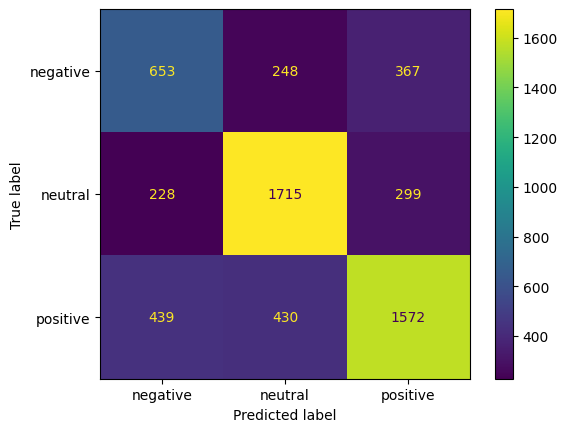

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lgbm,X_test,
                                      y_test,display_labels=le.classes_)